In [1]:
import keras
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import awkward as ak

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
# features
with uproot.open(f"root_files/ntuple_merged_0.root:deepntuplizer/tree;42") as tree:
    features = ['fj_jetNTracks','fj_nSV']+[x for x in tree.keys() if x[:6]=='fj_tau' or x[:8]=='fj_track'] 

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nlabels = len(labels)

In [4]:
def get_labels(tree,label):
    prods = label.split('*')
    facts = tree.arrays(prods,library='np')
    labels = np.multiply(facts[prods[0]],facts[prods[1]])
    return labels

def get_features(file_name):
    
    with uproot.open(f"{file_name}:deepntuplizer/tree;42") as tree:

        feature_array = np.stack(list(tree.arrays(features,library='np').values()),axis=-1)
        label_array = np.stack([get_labels(tree,i) for i in labels],axis=-1)
        feature_array = feature_array[np.sum(label_array,axis=1)==1]
        label_array = label_array[np.sum(label_array,axis=1)==1]
        
    return feature_array, label_array

In [5]:
feature_array, label_array = get_features('root_files/ntuple_merged_10.root')

In [6]:
keras_model = keras.Sequential()
keras_model.add(Dense(units=32,activation='relu',input_dim=nfeatures))
keras_model.add(Dense(units=32,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1024      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,146
Trainable params: 2,146
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
24644 + 163175

187819

In [8]:
# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=100, validation_split=0.2)

Epoch 1/100
 68/147 [============>.................] - ETA: 0s - loss: 0.4930 - accuracy: 0.8614 

2022-09-28 18:04:45.000666: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


147/147 [==============================] - 0s 2ms/step - loss: 0.3836 - accuracy: 0.8788 - val_loss: 0.2771 - val_accuracy: 0.8949
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2644 - accuracy: 0.8981 - val_loss: 0.2612 - val_accuracy: 0.8988
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2517 - accuracy: 0.9023 - val_loss: 0.2511 - val_accuracy: 0.9020
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2431 - accuracy: 0.9053 - val_loss: 0.2426 - val_accuracy: 0.9054
Epoch 5/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2353 - accuracy: 0.9081 - val_loss: 0.2347 - val_accuracy: 0.9074
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2263 - accuracy: 0.9113 - val_loss: 0.2274 - val_accuracy: 0.9105
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.2190 - accuracy: 0.9139 - val_loss: 0.2166 - val_accuracy: 0.9141
Epoch 8/100

Epoch 58/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1626 - accuracy: 0.9358 - val_loss: 0.1694 - val_accuracy: 0.9332
Epoch 59/100
147/147 [==============================] - 0s 999us/step - loss: 0.1615 - accuracy: 0.9368 - val_loss: 0.1694 - val_accuracy: 0.9326
Epoch 60/100
147/147 [==============================] - 0s 996us/step - loss: 0.1616 - accuracy: 0.9368 - val_loss: 0.1688 - val_accuracy: 0.9334
Epoch 61/100
147/147 [==============================] - 0s 995us/step - loss: 0.1618 - accuracy: 0.9365 - val_loss: 0.1700 - val_accuracy: 0.9338
Epoch 62/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1616 - accuracy: 0.9362 - val_loss: 0.1739 - val_accuracy: 0.9323
Epoch 63/100
147/147 [==============================] - 0s 1ms/step - loss: 0.1608 - accuracy: 0.9371 - val_loss: 0.1674 - val_accuracy: 0.9340
Epoch 64/100
147/147 [==============================] - 0s 996us/step - loss: 0.1604 - accuracy: 0.9375 - val_loss: 0.1674 - val_a

In [9]:
# load testing file
feature_array_test, label_array_test = get_features('root_files/ntuple_merged_0.root')

5873/5873 [==============================] - 1s 233us/step


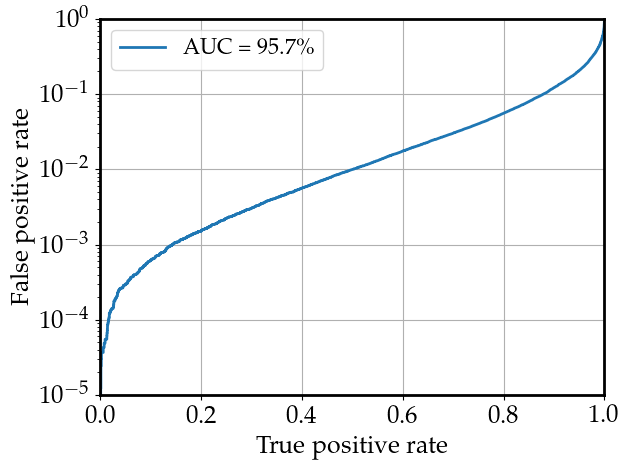

In [10]:
# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(1e-5,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.pdf')
plt.show()